## Imports

In [2]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, AveragePooling2D, Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.datasets import mnist, cifar10
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# MNIST

In [11]:
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Create model

In [4]:
input = Input(shape=(784,))
encoded = Dense(32, activation='relu')(input)
decoded = Dense(784, activation='sigmoid')(encoded)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
autoencoder = Model(input, decoded)

In [0]:
autoencoder.compile(optimizer=sgd, loss='binary_crossentropy')

## Prepare data and run model

In [0]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [0]:
sgd = SGD(lr=0.0016)

In [24]:
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 2/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 3/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 4/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 5/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 6/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 7/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 8/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0990 - val_loss: 0.0977
Epoch 9/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0990 - val_loss: 0.0

## Predictions

In [0]:
preds = autoencoder.predict(x_test)

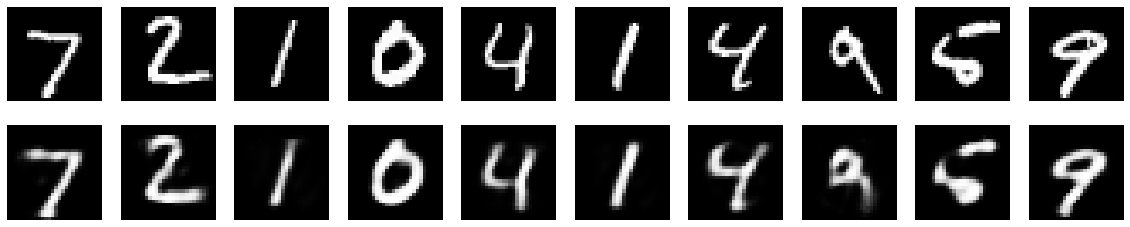

In [32]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(preds[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CIFAR-10

Code from [this file](https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py).

## Set options

In [0]:
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [0]:
n = 3  # for ResNet20 v1

In [0]:
version = 1

In [0]:
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

## Load data

In [11]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 46s 0us/step


In [0]:
input_shape = x_train.shape[1:]

In [0]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [15]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Define ResNet blocks and architecture

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
            
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Create model

In [0]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

## Model compilation

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(1e-3, decay=1e-3),  # we will compute this later
              metrics=['accuracy'])

In [0]:
save_dir = 'gdrive/My Drive/'

In [0]:
model_name = 'cifar10_model.{epoch:03d}.h5'

In [0]:
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

## Fit function

In [0]:
def fit(epochs):
    # Run training, with or without data augmentation.
    if not data_augmentation:
        print('Not using data augmentation.')
        return model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(x_test, y_test),
                  shuffle=True,
                  callbacks=[checkpoint])
    else:
        print('Using real-time data augmentation.')
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (deg 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally
            width_shift_range=0.1,
            # randomly shift images vertically
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            # randomly flip images
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        
        steps_per_epoch = len(x_train) / batch_size

        # Fit the model on the batches generated by datagen.flow().
        return model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=steps_per_epoch,
                            validation_data=(x_test, y_test),
                            epochs=epochs, verbose=1, workers=4,
                            callbacks=[checkpoint])

## Compute $K_z$

In [131]:
fit(1)

Using real-time data augmentation.
Epoch 1/1
391/390 [==============================] - 57s 145ms/step - loss: 2.5275 - acc: 0.1688 - val_loss: 2.2917 - val_acc: 0.2055

Epoch 00001: val_acc improved from -inf to 0.20550, saving model to gdrive/My Drive/cifar10_model.001.h5


In [67]:
model.layers

In [0]:
func = K.function([model.layers[0].input], [model.layers[-3].output])

In [133]:
Kz = 0.

for i in range((len(x_train) - 1) // 128 + 1):
    start_i = i * 128
    end_i = start_i + 128
    xb = x_train[start_i:end_i]
    
    activ = np.linalg.norm(func([xb]))
    if activ > Kz:
        Kz = activ

print('Kz =', Kz)

Kz = 172.2095


In [134]:
sess = K.get_session()
max_wt = 0.
for weight in model.weights:
    norm = np.linalg.norm(weight.eval(sess))
    if norm > max_wt:
        max_wt = norm

print('Max norm =', max_wt)

Max norm = 36.185123


## Find learning rate and fit

In [0]:
K_ = Kz / (2. * 128) + 1e-3 * max_wt  # 128 = Batch size

In [0]:
lr = 1 / K_

In [137]:
print('Learning rate =', lr)

Learning rate = 1.4106789904732149


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr, decay=1e-3,),  # we will compute this later
              metrics=['accuracy'])

In [0]:
!rm gdrive/"My Drive/cifar10_model.001.h5"

In [140]:
fit(100)

Using real-time data augmentation.
Epoch 1/100
391/390 [==============================] - 56s 144ms/step - loss: 2.3233 - acc: 0.2825 - val_loss: 2.0363 - val_acc: 0.3604

Epoch 00001: val_acc improved from 0.20550 to 0.36040, saving model to gdrive/My Drive/cifar10_model.001.h5
Epoch 2/100
391/390 [==============================] - 47s 119ms/step - loss: 1.7588 - acc: 0.4484 - val_loss: 1.8160 - val_acc: 0.4314

Epoch 00002: val_acc improved from 0.36040 to 0.43140, saving model to gdrive/My Drive/cifar10_model.002.h5
Epoch 3/100
391/390 [==============================] - 47s 120ms/step - loss: 1.5709 - acc: 0.5141 - val_loss: 1.5495 - val_acc: 0.5258

Epoch 00003: val_acc improved from 0.43140 to 0.52580, saving model to gdrive/My Drive/cifar10_model.003.h5
Epoch 4/100
391/390 [==============================] - 47s 119ms/step - loss: 1.4306 - acc: 0.5628 - val_loss: 1.7419 - val_acc: 0.4815

Epoch 00004: val_acc did not improve from 0.52580
Epoch 5/100
391/390 [======================

In [0]:
model.save('gdrive/My Drive/epoch-100-resnet20-v1.h5')

In [0]:
history_100 = model.history

In [144]:
history_100.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

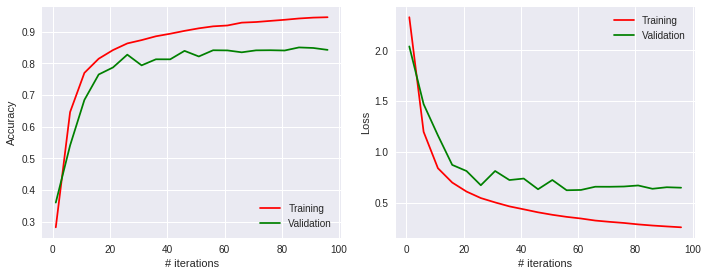

In [145]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].set_ylabel('Accuracy');
ax[0].set_xlabel('# iterations');
lines = ax[0].plot(range(1, 101, 5), history_100.history['acc'][::5], 'r-',
                   range(1, 101, 5), history_100.history['val_acc'][::5], 'g-');
ax[0].legend(lines, ('Training', 'Validation'));

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# iterations')
lines = ax[1].plot(range(1, 101, 5), history_100.history['loss'][::5], 'r-',
                   range(1, 101, 5), history_100.history['val_loss'][::5], 'g-');
ax[1].legend(lines, ('Training', 'Validation'))

fig.tight_layout()

In [146]:
fit(100)

Using real-time data augmentation.
Epoch 1/100
391/390 [==============================] - 47s 121ms/step - loss: 0.2482 - acc: 0.9485 - val_loss: 0.6983 - val_acc: 0.8421

Epoch 00001: val_acc did not improve from 0.85700
Epoch 2/100
391/390 [==============================] - 46s 118ms/step - loss: 0.2446 - acc: 0.9501 - val_loss: 0.6322 - val_acc: 0.8535

Epoch 00002: val_acc did not improve from 0.85700
Epoch 3/100
391/390 [==============================] - 46s 119ms/step - loss: 0.2422 - acc: 0.9508 - val_loss: 0.6587 - val_acc: 0.8510

Epoch 00003: val_acc did not improve from 0.85700
Epoch 4/100
391/390 [==============================] - 46s 119ms/step - loss: 0.2455 - acc: 0.9480 - val_loss: 0.7009 - val_acc: 0.8414

Epoch 00004: val_acc did not improve from 0.85700
Epoch 5/100
391/390 [==============================] - 46s 119ms/step - loss: 0.2424 - acc: 0.9494 - val_loss: 0.6318 - val_acc: 0.8550

Epoch 00005: val_acc did not improve from 0.85700
Epoch 6/100
391/390 [=========

In [5]:
model = keras.models.load_model('gdrive/My Drive/cifar10_model.096.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [26]:
history_300 = fit(104)

Using real-time data augmentation.
Epoch 1/104
391/390 [==============================] - 48s 123ms/step - loss: 0.1565 - acc: 0.9753 - val_loss: 0.6562 - val_acc: 0.8635

Epoch 00001: val_acc improved from -inf to 0.86350, saving model to gdrive/My Drive/cifar10_model.001.h5
Epoch 2/104
391/390 [==============================] - 43s 109ms/step - loss: 0.1526 - acc: 0.9763 - val_loss: 0.6869 - val_acc: 0.8568

Epoch 00002: val_acc did not improve from 0.86350
Epoch 3/104
391/390 [==============================] - 43s 109ms/step - loss: 0.1541 - acc: 0.9756 - val_loss: 0.6170 - val_acc: 0.8650

Epoch 00003: val_acc improved from 0.86350 to 0.86500, saving model to gdrive/My Drive/cifar10_model.003.h5
Epoch 4/104
391/390 [==============================] - 43s 109ms/step - loss: 0.1533 - acc: 0.9765 - val_loss: 0.7808 - val_acc: 0.8438

Epoch 00004: val_acc did not improve from 0.86500
Epoch 5/104
391/390 [==============================] - 43s 109ms/step - loss: 0.1556 - acc: 0.9755 - val

In [0]:
model.save('gdrive/My Drive/epoch-300-resnet20-v1.h5')

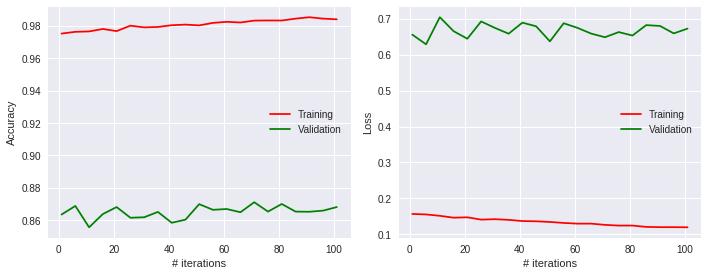

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

ax[0].set_ylabel('Accuracy');
ax[0].set_xlabel('# iterations');
lines = ax[0].plot(range(1, 105, 5), history_300.history['acc'][::5], 'r-',
                   range(1, 105, 5), history_300.history['val_acc'][::5], 'g-');
ax[0].legend(lines, ('Training', 'Validation'));

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# iterations')
lines = ax[1].plot(range(1, 105, 5), history_300.history['loss'][::5], 'r-',
                   range(1, 105, 5), history_300.history['val_loss'][::5], 'g-');
ax[1].legend(lines, ('Training', 'Validation'))

fig.tight_layout()

In [0]:
history_400 = fit(100)

Using real-time data augmentation.
Epoch 1/100
391/390 [==============================] - 43s 110ms/step - loss: 0.1146 - acc: 0.9857 - val_loss: 0.6723 - val_acc: 0.8640

Epoch 00001: val_acc did not improve from 0.87290
Epoch 2/100
391/390 [==============================] - 43s 109ms/step - loss: 0.1155 - acc: 0.9855 - val_loss: 0.6977 - val_acc: 0.8646

Epoch 00002: val_acc did not improve from 0.87290
Epoch 3/100
391/390 [==============================] - 43s 109ms/step - loss: 0.1144 - acc: 0.9858 - val_loss: 0.6622 - val_acc: 0.8729

Epoch 00003: val_acc did not improve from 0.87290
Epoch 4/100
391/390 [==============================] - 43s 110ms/step - loss: 0.1141 - acc: 0.9858 - val_loss: 0.6545 - val_acc: 0.8739

Epoch 00004: val_acc improved from 0.87290 to 0.87390, saving model to gdrive/My Drive/cifar10_model.004.h5
Epoch 5/100
391/390 [==============================] - 43s 110ms/step - loss: 0.1153 - acc: 0.9852 - val_loss: 0.6977 - val_acc: 0.8632

Epoch 00005: val_acc d

In [0]:
model